# Sequence Models

Using data from yahoo finance, create a RNN, LSTM, and GRU to give predicitons of closing prices for Nividia stock.

Compare each model with each other to see which does better in making predictions. 

Build a multi-variable LSTM with the same Nividia stock data from yahoo finance and see how well it performs.

In [1]:
import yfinance as yf

nvidia_data = yf.Ticker("NVDA")

In [2]:
nvidia_price_df = nvidia_data.history(period='max')[['Close']]

In [3]:
nvidia_price_df

,Close
Date,
1999-01-22 00:00:00-05:00,0.037605
1999-01-25 00:00:00-05:00,0.041545
1999-01-26 00:00:00-05:00,0.038321
1999-01-27 00:00:00-05:00,0.038202
1999-01-28 00:00:00-05:00,0.038082
...,...
2025-12-01 00:00:00-05:00,179.909988
2025-12-02 00:00:00-05:00,181.449905
2025-12-03 00:00:00-05:00,179.580002


In [4]:
import pandas as pd
nvidia_price_df.to_csv('data/nvidia_stock_price_max_hist.csv')

In [5]:
nvidia_price_df.describe()

,Close
count,6761.000000
mean,13.141670
std,34.654923
min,0.031278
25%,0.262215
50%,0.447219
75%,5.475042
max,207.028473


In [6]:
nvidia_close = nvidia_price_df[['Close']]

array([[<Axes: title={'center': 'Close'}>]], dtype=object)

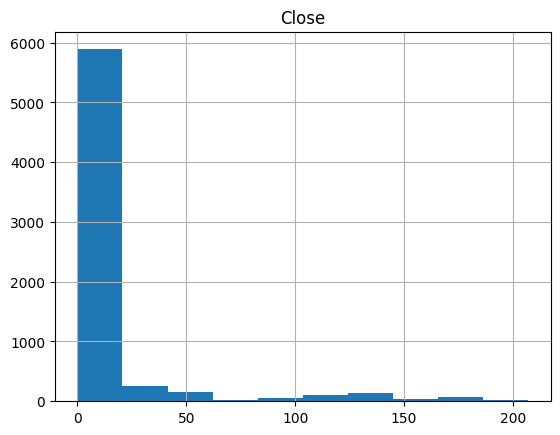

In [7]:
import matplotlib.pyplot as plt
nvidia_close.hist()

<Axes: xlabel='Date'>

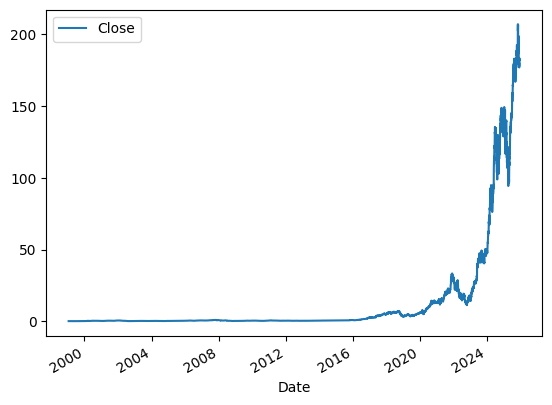

In [8]:
nvidia_close.plot()

In [9]:
nvidia_close_norm = (nvidia_close - nvidia_close.min()) / (nvidia_close.max() - nvidia_close.min())

<Axes: xlabel='Date'>

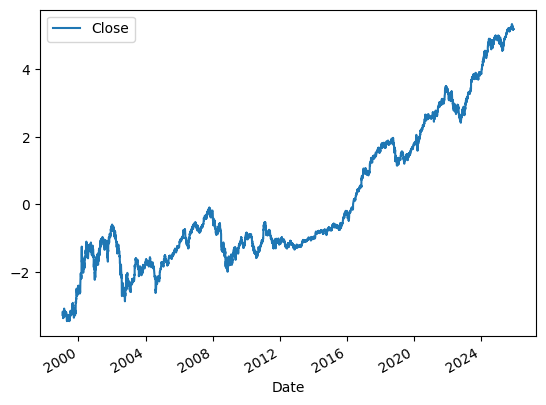

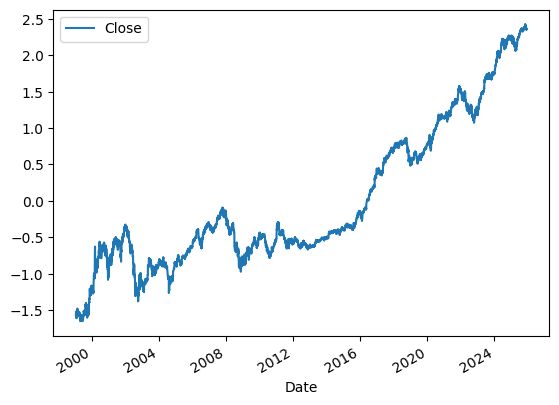

In [10]:
import numpy as np
nv_log = np.log(nvidia_close)
nv_log.plot()
nv = (nv_log - nv_log.mean()) / nv_log.std()
nv.plot()

In [1]:
from data_handler import (
    extract_stock_close_price,
    log_transformation,
    standardization,
    split_data,
    sliding_window,
    split_feature_targets,
)

file = 'data/nvidia_stock_price_max_hist.csv'
close_raw = extract_stock_close_price("NVDA", "max", file, "Close")

test_ratio = 0.20
train_temp, test_raw = split_data(close_raw, test_ratio)

val_ratio = 0.20
train_raw, val_raw = split_data(train_temp, val_ratio)

train_log = log_transformation(train_raw)
train_clean, train_log_mean, train_log_std = standardization(train_log)

val_log = log_transformation(val_raw)
val_clean = (val_log - train_log_mean) / train_log_std

test_log = log_transformation(test_raw)
test_clean = (test_log - train_log_mean) / train_log_std


In [2]:
window_size = 20
window_step = 2
val_ratio = 0.20

train_set = sliding_window(train_clean, window_size, window_step)
X_train, y_train = split_feature_targets(train_set)

val_set = sliding_window(val_clean, window_size, window_step)
X_val, y_val = split_feature_targets(val_set)

test_set = sliding_window(test_clean, window_size, window_step)
X_test, y_test = split_feature_targets(test_set)

In [3]:
from sequence_model import SimpleRNN, train_model
rnn = SimpleRNN()
num_epochs=10
batch_size=32
learning_rate=0.002
train_loss, val_loss = train_model(rnn, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val)

Epoch 1
Train loss: 0.7589502616764923
Val Loss: 0.522463649730472
Epoch 2
Train loss: 0.2297590163173428
Val Loss: 0.15562360985752413
Epoch 3
Train loss: 0.10748472109416445
Val Loss: 0.08586008972762262
Epoch 4
Train loss: 0.05782688106667004
Val Loss: 0.04714466378037982
Epoch 5
Train loss: 0.029799095848027396
Val Loss: 0.028497885940048623
Epoch 6
Train loss: 0.0165145181116018
Val Loss: 0.0195590312976171
Epoch 7
Train loss: 0.011384446314396508
Val Loss: 0.013597888625500834
Epoch 8
Train loss: 0.008772451923398287
Val Loss: 0.013095248408396454
Epoch 9
Train loss: 0.007080656991627834
Val Loss: 0.010693078833248685
Epoch 10
Train loss: 0.005394651692982092
Val Loss: 0.008256920873570968


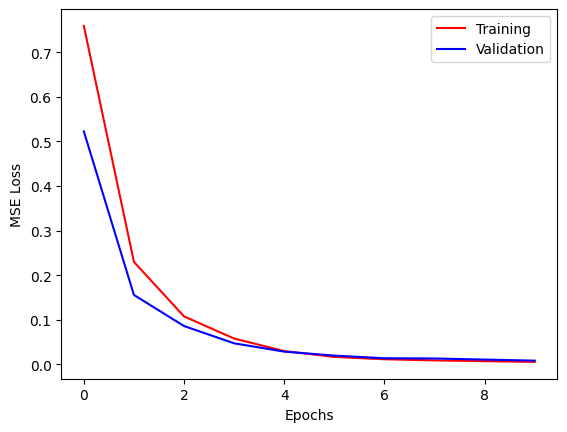

In [4]:
import matplotlib.pyplot as plt
epochs = [*range(num_epochs)]
plt.plot(epochs, train_loss, label="Training", color="red")
plt.plot(epochs, val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [5]:
from sequence_model import test_model

all_pred, test_losses = test_model(rnn, X_test, y_test)

In [7]:
from data_handler import inverse_transform

final_pred = inverse_transform(all_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

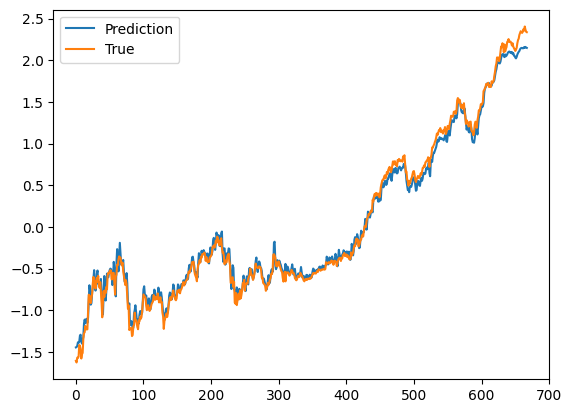

In [8]:
plt.plot(all_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

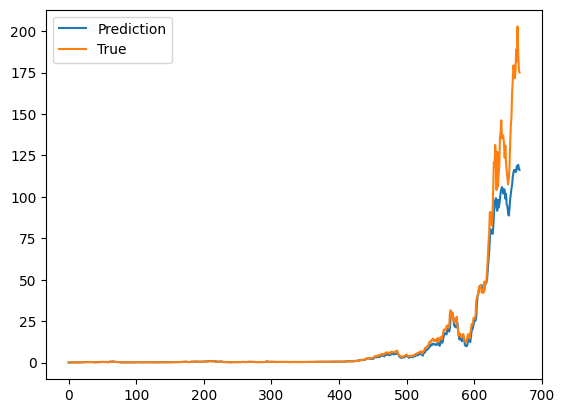

In [9]:
plt.plot(final_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()

# LSTM

In [23]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim
import numpy as np
from numpy.typing import NDArray


class SimpleLSTM(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=8, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=8, out_features=1)

    def forward(self, input):  # x (batch, seq_len, input_size)
        output, (hx, cn) = self.lstm(input)
        y_hat = self.fc(output[:,-1,:])

        return y_hat

In [24]:
from sequence_model import train_model
lstm = SimpleLSTM()
num_epochs=10
batch_size=32
learning_rate=0.002
train_loss, val_loss = train_model(lstm, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val)

Epoch 1
Train loss: 0.83438369679703
Val Loss: 0.5676137217703987
Epoch 2
Train loss: 0.24834322151282856
Val Loss: 0.12085481333162855
Epoch 3
Train loss: 0.18318420302431845
Val Loss: 0.09678041490192033
Epoch 4
Train loss: 0.05669535747866201
Val Loss: 0.055562034838230294
Epoch 5
Train loss: 0.05026971490823438
Val Loss: 0.041502745048252535
Epoch 6
Train loss: 0.030509386826773097
Val Loss: 0.03274739191264791
Epoch 7
Train loss: 0.02314406458283295
Val Loss: 0.021609122440328494
Epoch 8
Train loss: 0.014839169712264693
Val Loss: 0.013934472972965416
Epoch 9
Train loss: 0.009700921456148053
Val Loss: 0.010226300280705532
Epoch 10
Train loss: 0.007126191784075619
Val Loss: 0.008292459081584477


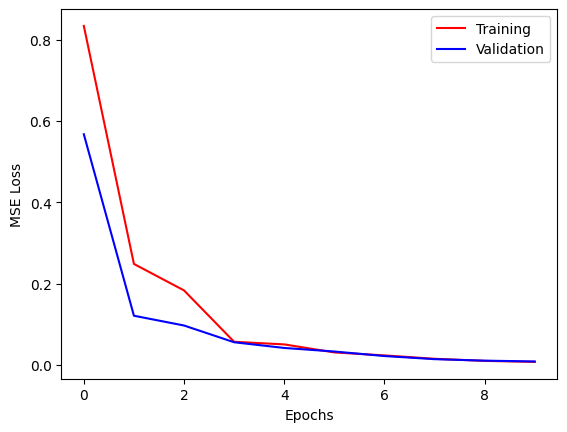

In [25]:
import matplotlib.pyplot as plt
epochs = [*range(num_epochs)]
plt.plot(epochs, train_loss, label="Training", color="red")
plt.plot(epochs, val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [26]:
from sequence_model import test_model
from data_handler import inverse_transform

all_pred, test_losses = test_model(rnn, X_test, y_test)

final_pred = inverse_transform(all_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

In [38]:
final_loss = test_losses[-1]
print(final_loss)

tensor(0.0357, device='mps:0')


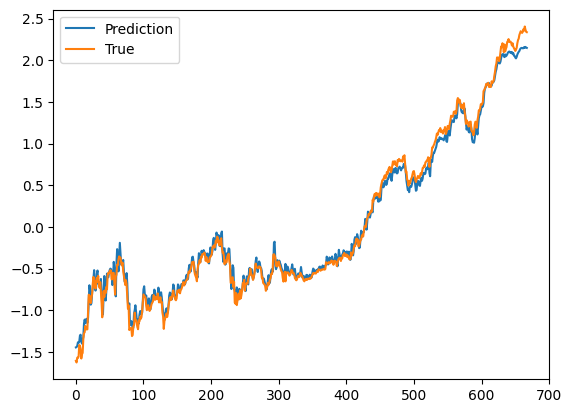

In [30]:
plt.plot(all_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

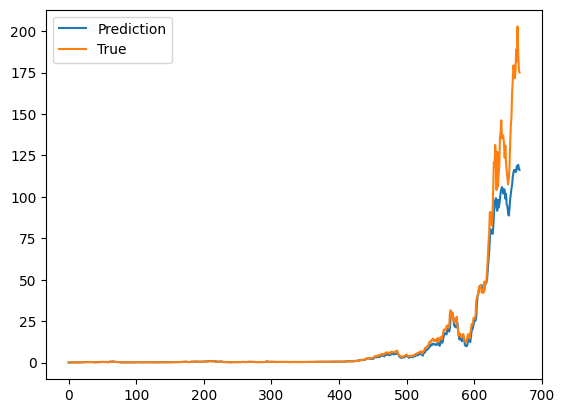

In [28]:
plt.plot(final_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()